In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
!gunzip cc.ta.300.vec.gz
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

--2025-04-15 11:24:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1213735937 (1.1G) [binary/octet-stream]
Saving to: ‘cc.ta.300.vec.gz’

cc.ta.300.vec.gz    100%[===================>]   1.13G   400MB/s    in 2.9s    

2025-04-15 11:24:34 (400 MB/s) - ‘cc.ta.300.vec.gz’ saved [1213735937/1213735937]



In [2]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 11:25:16.502399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744716316.695073      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744716316.758418      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_ta = pd.read_csv("/kaggle/input/gender-abuse-dataset/train_ta_l1.csv")
annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']

def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0 if valid_votes else None

df_ta['label'] = df_ta[annotation_cols].apply(get_majority_label, axis=1)
df_ta = df_ta[['text', 'label']].dropna()
df_ta['label'] = df_ta['label'].astype(int)


def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_ta['text'] = df_ta['text'].apply(normalize_text)

# Tokenization
max_features = 10000  # Set this based on your dataset size
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df_ta['text'])
X_seq_ta = keras_tokenizer.texts_to_sequences(df_ta['text'])
X_ta = pad_sequences(X_seq_ta, maxlen=max_len, padding='post')

# Labels
label_encoder = LabelEncoder()
y_ta = label_encoder.fit_transform(df_ta['label'])

word_index = keras_tokenizer.word_index

# Load fasttex embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
with open('cc.ta.300.vec', encoding="utf8") as f:
    next(f)  # Skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in word_index:
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix[word_index[word]] = coefs

In [4]:
class FusionDataset(Dataset):
    def __init__(self, texts, fasttex_inputs, labels, tokenizer, max_len=128):
        self.texts = texts
        self.fasttex_inputs = fasttex_inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': bert_encoded['input_ids'].squeeze(),
            'attention_mask': bert_encoded['attention_mask'].squeeze(),
            'fasttex_input': torch.tensor(self.fasttex_inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [5]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [6]:
# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, n_heads=4):
#         super(FusionClassifier, self).__init__()
#         self.bert_encoder = IndicBERTEncoder()
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)
#         self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=n_heads, batch_first=True)
#         self.classifier = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 2)
#         )

#     def forward(self, input_ids, attention_mask, fasttex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)        # (B, 128)
#         x2 = self.bilstm_encoder(fasttex_input)                    # (B, 128)
#         combined = torch.stack([x1, x2], dim=1)                  # (B, 2, 128)
#         attn_output, _ = self.attention(combined, combined, combined)
#         pooled = attn_output.mean(dim=1)                         # (B, 128)
#         return self.classifier(pooled)                           # (B, 2)


In [7]:

# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix):
#         super(FusionClassifier, self).__init__()

#         self.bert_encoder = IndicBERTEncoder()             # Outputs x1 (B, 128)
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)  # Outputs x2 (B, 128)

#         # Use attention over 4 vectors: x1, x2, x1 - x2, x1 * x2
#         self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

#         # MLP head after attention
#         self.fusion_head = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 2)  # Output logits
#         )

#     def forward(self, input_ids, attention_mask, fasttex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)     # (B, 128)
#         x2 = self.bilstm_encoder(fasttex_input)                 # (B, 128)

#         # Stack fused representations into a pseudo-sequence (B, 4, 128)
#         fusion_seq = torch.stack([x1, x2, x1 - x2, x1 * x2], dim=1)

#         # Apply attention across the 4 vectors
#         attn_out, _ = self.attn(fusion_seq, fusion_seq, fusion_seq)  # (B, 4, 128)

#         # Pool (mean) across the 4 outputs
#         pooled = attn_out.mean(dim=1)  # (B, 128)

#         return self.fusion_head(pooled)

In [8]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super(FusionClassifier, self).__init__()
        
        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        # Fusion output dimension: concat + contrast = 512
        self.fusion_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # Output logits
        )

    def forward(self, input_ids, attention_mask, fasttex_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(fasttex_input)               # (B, 128)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2], dim=1)     # (B, 512)
        return self.fusion_head(x) 

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]


Epoch 1/13


Training:   0%|          | 0/339 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.7151 | Val Loss: 0.6743 | F1: 0.4956 | Precision: 0.6788 | Recall: 0.6032
Saved best model (F1: 0.4956)

Epoch 2/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.6234 | Val Loss: 0.5665 | F1: 0.7181 | Precision: 0.7226 | Recall: 0.7235
Saved best model (F1: 0.7181)

Epoch 3/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5853 | Val Loss: 0.5553 | F1: 0.7208 | Precision: 0.7496 | Recall: 0.7205
Saved best model (F1: 0.7208)

Epoch 4/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5724 | Val Loss: 0.5322 | F1: 0.7329 | Precision: 0.7387 | Recall: 0.7316
Saved best model (F1: 0.7329)

Epoch 5/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5597 | Val Loss: 0.5302 | F1: 0.7153 | Precision: 0.7606 | Recall: 0.7168

Epoch 6/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5477 | Val Loss: 0.5211 | F1: 0.7436 | Precision: 0.7646 | Recall: 0.7426
Saved best model (F1: 0.7436)

Epoch 7/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5359 | Val Loss: 0.5347 | F1: 0.7199 | Precision: 0.7580 | Recall: 0.7205

Epoch 8/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5330 | Val Loss: 0.5141 | F1: 0.7585 | Precision: 0.7590 | Recall: 0.7581
Saved best model (F1: 0.7585)

Epoch 9/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5262 | Val Loss: 0.5221 | F1: 0.7255 | Precision: 0.7667 | Recall: 0.7264

Epoch 10/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5173 | Val Loss: 0.5183 | F1: 0.7581 | Precision: 0.7599 | Recall: 0.7574

Epoch 11/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5194 | Val Loss: 0.5154 | F1: 0.7533 | Precision: 0.7714 | Recall: 0.7522

Epoch 12/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5160 | Val Loss: 0.5133 | F1: 0.7543 | Precision: 0.7621 | Recall: 0.7529

Epoch 13/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5103 | Val Loss: 0.5207 | F1: 0.7606 | Precision: 0.7608 | Recall: 0.7603


/tmp/ipykernel_31/4226811564.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_tamil_task1.pt"))


Saved best model (F1: 0.7606)



Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.79      0.79      0.79       778
        Hate       0.72      0.73      0.72       578

    accuracy                           0.76      1356
   macro avg       0.76      0.76      0.76      1356
weighted avg       0.76      0.76      0.76      1356



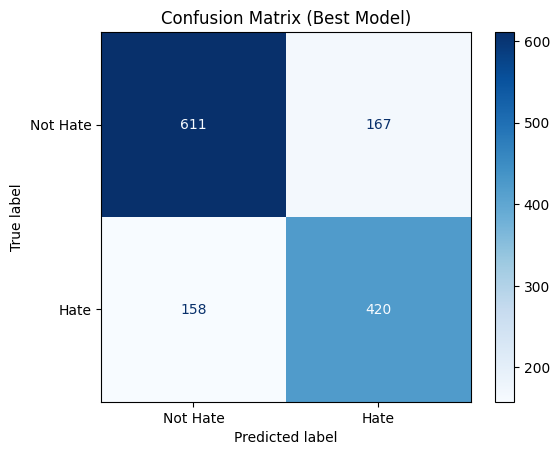

In [9]:
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
train_texts, val_texts, train_glove, val_glove, train_y, val_y = train_test_split(
    df_ta['text'].tolist(), X_ta, y_ta, test_size=0.2, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
label_counts = Counter(train_y)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = [w / sum(class_weights) for w in class_weights]
class_weights_tensor = torch.tensor(class_weights).to(device)

train_dataset = FusionDataset(train_texts, train_glove, train_y, tokenizer)
val_dataset = FusionDataset(val_texts, val_glove, val_y, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


model = FusionClassifier(embedding_matrix).to(device)
    
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
    
# Training Loop
train_losses, val_losses = [], []
best_f1 = 0.0
    
for epoch in range(13):
    print(f"\nEpoch {epoch + 1}/13")
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            targets += labels.cpu().tolist()
    print("Unique predictions in this epoch:", set(preds))
    print("Unique true labels:", set(targets))
    
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_losses.append(avg_val_loss)
    
    f1 = f1_score(targets, preds, average="weighted")
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")
    
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    
    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_tamil_task1.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f"Saved best model (F1: {best_f1:.4f})")
    
# Final Evaluation
model.load_state_dict(torch.load("fusion_tamil_task1.pt"))
model.eval()
    
final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        final_preds += torch.argmax(outputs, dim=1).cpu().tolist()
        final_targets += labels.cpu().tolist()
    
# Final Report
print("\nFinal Classification Report:\n")
print(classification_report(final_targets, final_preds, target_names=["Not Hate", "Hate"]))
    
cm = confusion_matrix(final_targets, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Model)")
plt.show()

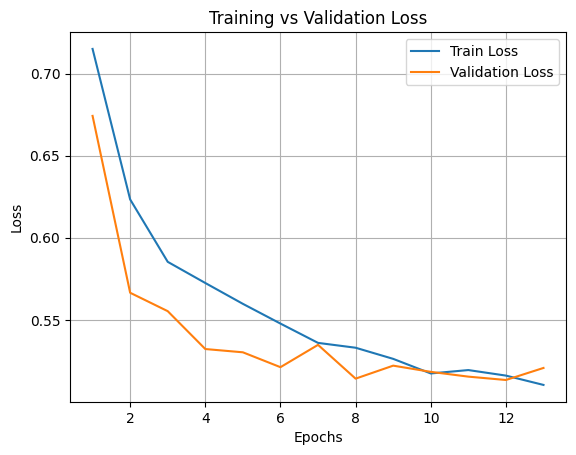

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/934460642.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_tamil_task1.pt"))


Saved predictions to: Task1_output_tamil.csv

F1-score: 0.7548 | Precision: 0.7588 | Recall: 0.7551

Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.72      0.80      0.76       548
        Hate       0.79      0.71      0.75       587

    accuracy                           0.76      1135
   macro avg       0.76      0.76      0.75      1135
weighted avg       0.76      0.76      0.75      1135



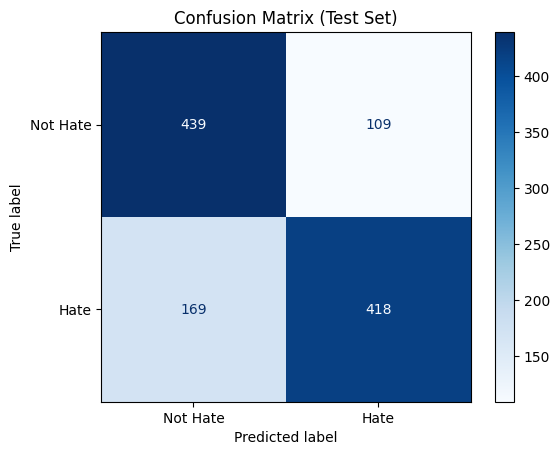

In [11]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess test data
test_df = pd.read_csv("/kaggle/input/gender-abuse-dataset/test_ta_l1.csv")
annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5']
test_df['label'] = test_df[annotation_cols].apply(get_majority_label, axis=1)
test_df = test_df[['text', 'label']].dropna()
test_df['label'] = test_df['label'].astype(int)
test_df['text'] = test_df['text'].apply(normalize_text)

# Tokenize and encode
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_labels = test_df['label'].tolist()
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix).to(device)
model.load_state_dict(torch.load("fusion_tamil_task1.pt"))
model.eval()

# Run inference
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(labels.cpu().tolist())
        
output_df = pd.DataFrame({'id': np.arange(1, len(all_preds)+1), 'value': all_preds})
output_df.to_csv('/kaggle/working/Task1_output_English.csv', index=False)
print("Saved predictions to: Task1_output_tamil.csv")

f1 = f1_score(all_targets, all_preds, average="weighted")
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
print(f"\nF1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()
